# Assignment 3

## Question 1
**Data Exploration and Visualization** (15 pts): 
- Explore the Melbourne house dataset. 
- Provide visualizations such as histograms, scatter plots, or box plots to understand the 
distribution of different features. 
- Include any other plots you find interesting and provide brief interpretations.

In [1]:
# I import and read the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition

/var/folders/82/1fv9h9_j6nzg4ys2y06tyw780000gn/T/ipykernel_86649/397048979.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#upload file onto data framw
Housing_df = pd.read_csv("/Users/Gustavo/Library/CloudStorage/Dropbox/UC Davis/2024 - Winter/ML/Assignments ML/HW3/Melbourne_housing.csv")
pd.set_option('display.max_columns', 25)
print(Housing_df.shape)

(499, 21)


In [3]:
# I check the amount of missing values in the data set
def display_missing_perc(Housing_df):
    """
    This is a function that evaluates the percentage of NA values per column
    """
    for col in Housing_df.columns.tolist():          
        missing_value = 100*(Housing_df[col].isnull().sum()/len(Housing_df[col]))
        missing_num = Housing_df[col].isnull().sum()
        print(f'{col} column missing values: {missing_value} ; total missing: {missing_num}') # Here, I can also see the total number of missing values.
    print('\n')
display_missing_perc(Housing_df)


Suburb column missing values: 0.0 ; total missing: 0
Address column missing values: 0.0 ; total missing: 0
Rooms column missing values: 0.0 ; total missing: 0
Type column missing values: 0.0 ; total missing: 0
Price column missing values: 21.64328657314629 ; total missing: 108
Method column missing values: 0.0 ; total missing: 0
SellerG column missing values: 0.0 ; total missing: 0
Date column missing values: 0.0 ; total missing: 0
Distance column missing values: 0.0 ; total missing: 0
Postcode column missing values: 0.0 ; total missing: 0
Bedroom2 column missing values: 25.651302605210418 ; total missing: 128
Bathroom column missing values: 25.651302605210418 ; total missing: 128
Car column missing values: 27.45490981963928 ; total missing: 137
Landsize column missing values: 34.86973947895792 ; total missing: 174
BuildingArea column missing values: 62.124248496993985 ; total missing: 310
YearBuilt column missing values: 57.51503006012024 ; total missing: 287
CouncilArea column missin

In [4]:
#I remove any unnamed columns
Housing_df = Housing_df.loc[:, ~Housing_df.columns.str.contains('^Unnamed')]
Housing_df.dtypes

Suburb            object
Address           object
Rooms              int64
Type              object
Price            float64
Method            object
SellerG           object
Date              object
Distance         float64
Postcode           int64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
CouncilArea       object
Lattitude        float64
Longtitude       float64
Regionname        object
Propertycount      int64
dtype: object

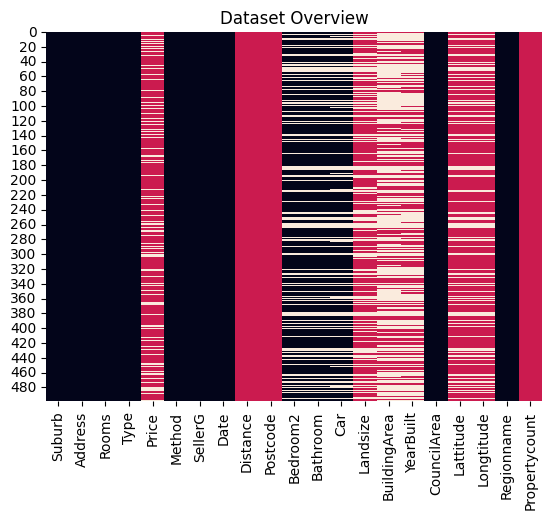

 Categerocial   Numeric   NaN 


In [5]:
#This is function to visualize the NA values.
#it is a heatmap to see how many NA values per column.
def utils_recognize_type(dtf, col, max_cat=20):
    if (dtf[col].dtype == "O") | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"
dic_cols = {col:utils_recognize_type(Housing_df, col, max_cat=20) for col in Housing_df.columns}
heatmap = Housing_df.isnull()
for k,v in dic_cols.items():
    if v == "num":
        heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
    else:
        heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
plt.show()
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

The "BuildingArea" column has  62.1% of missing values, and the "YearBuilt" column has : 57.5% of missing values. I have decided to drop them. 
Also, for our purposes, longtude and lattitude bring the same kind of localization as the address, which is unique to each data entry. These don't tell us much about the data, unlike the postal code. Postal code can give us much more insights on the relation between location and price. Also, since longtude and lattitude have missing data, I have decided to drop them as well. 
Finally, the column "bedroom2" gives us the same data as the number of rooms, and it also has missing values. So I drop the column. 

In [6]:

Housing_df.drop(['Address','Bedroom2','BuildingArea','YearBuilt', 'Lattitude', 'Longtitude'], axis=1, inplace=True)

In [7]:
# I display all the object columns:
Housing_df.select_dtypes(include = 'object')

,Suburb,Type,Method,SellerG,Date,CouncilArea,Regionname
0,Thornbury,u,SP,Love,22/08/2016,Darebin City Council,Northern Metropolitan
1,Coburg,h,S,Peter,27/06/2016,Darebin City Council,Northern Metropolitan
2,Bentleigh East,u,S,Woodards,28/05/2016,Glen Eira City Council,Southern Metropolitan
3,Templestowe Lower,t,S,Jellis,25/11/2017,Manningham City Council,Eastern Metropolitan
4,South Yarra,u,PI,Jellis,10/9/2016,Melbourne City Council,Southern Metropolitan
...,...,...,...,...,...,...,...
494,Sunshine,h,S,Barry,26/08/2017,Brimbank City Council,Western Metropolitan
495,Springvale,h,S,Hall,24/06/2017,Greater Dandenong City Council,South-Eastern Metropolitan
496,Middle Park,h,VB,Greg,27/05/2017,Port Phillip City Council,Southern Metropolitan
497,Glenroy,h,SP,Raine,28/05/2016,Moreland City Council,Northern Metropolitan


In [8]:
# Display all the numeric columns (both float and int64):
Housing_df.select_dtypes(include=['float', 'int64'])


,Rooms,Price,Distance,Postcode,Bathroom,Car,Landsize,Propertycount
0,2,438000.0,6.5,3071,1.0,1.0,0.0,8870
1,2,901000.0,7.8,3058,1.0,1.0,545.0,11204
2,3,800000.0,13.9,3165,2.0,2.0,261.0,10969
3,3,1155000.0,12.4,3107,NaN,NaN,NaN,5420
4,3,1630000.0,3.3,3141,1.0,1.0,0.0,14887
...,...,...,...,...,...,...,...,...
494,2,965000.0,10.5,3020,1.0,1.0,NaN,3755
495,3,721000.0,20.8,3171,NaN,NaN,NaN,7412
496,3,1750000.0,3.0,3206,2.0,0.0,138.0,2019
497,3,501000.0,13.0,3046,1.0,1.0,348.0,8870


In [9]:
#With the 'Car'column, it's safe to assume that NaN values are 0, indicating that the property does not have a car spot.
Housing_df['Car'] = Housing_df['Car'].fillna(0)

In [10]:
Housing_df['Landsize'].value_counts()#this list all the unique values in our data set
#Housing_df['Landsize'].value_counts().idxmax() #this lists the most frequent values - the index of maximum values

Landsize
0.0       38
760.0      4
301.0      3
650.0      3
585.0      3
          ..
1215.0     1
139.0      1
200.0      1
239.0      1
1157.0     1
Name: count, Length: 245, dtype: int64

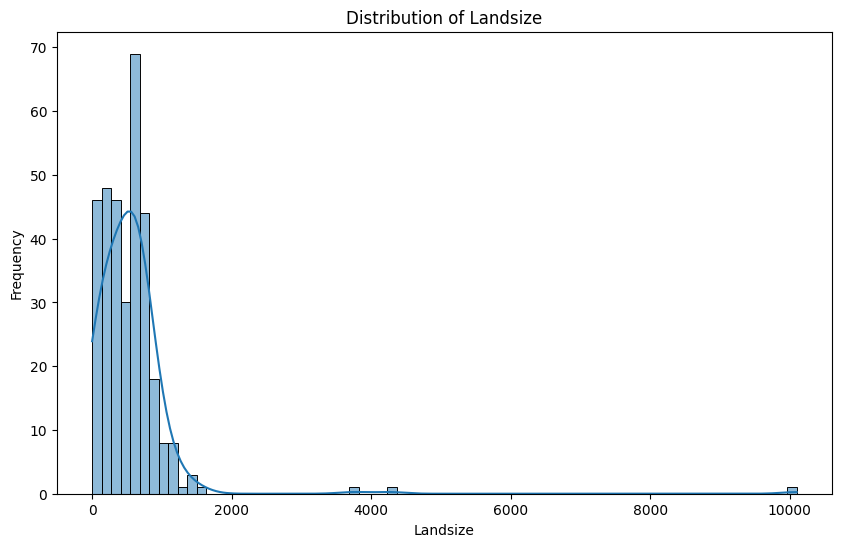

In [11]:
# Column Landsize presents several missing values and 38 values as 0. I create a plot. 
# Frequency counts of the 'diagnosis' column
#Landsize_counts = Housing_df['Landsize'].value_counts()
# Create a bar plot
plt.figure(figsize=(10, 6))
sns.histplot(Housing_df['Landsize'], kde=True)
plt.title('Distribution of Landsize')
plt.xlabel('Landsize')
plt.ylabel('Frequency')
plt.show()

In [12]:
num_nans = Housing_df['Landsize'].isna().sum()
print(f"Number of NaNs in the 'Landsize' column: {num_nans}")


Number of NaNs in the 'Landsize' column: 174


Because the column Landsize has  174 NaNs and 38 counts of 0.0, I have decided to drop it as well. 

In [13]:
Housing_df.drop(['Landsize'], axis=1, inplace=True)
Housing_df.dtypes

Suburb            object
Rooms              int64
Type              object
Price            float64
Method            object
SellerG           object
Date              object
Distance         float64
Postcode           int64
Bathroom         float64
Car              float64
CouncilArea       object
Regionname        object
Propertycount      int64
dtype: object

#### We explore our response variable

In [14]:
Housing_df['Price'].value_counts()#this list all the unique values in our data set

Price
570000.0     6
800000.0     6
950000.0     6
1300000.0    5
900000.0     4
            ..
495000.0     1
541000.0     1
547000.0     1
1880000.0    1
965000.0     1
Name: count, Length: 263, dtype: int64

In [15]:
#I check the number of missing values for the dependent variable
Housing_df['Price'].isnull().sum()


108

#### Trying to fill in the missing values with the median of the whole region of Melbourne is a bit risky. So, I decided to group prices according to Suburb first.

In [16]:
# Calculate the median price per suburb
median_price_Suburb = Housing_df.groupby('Suburb')['Price'].transform('median')

In [17]:
# Fill in missing values in the 'Price' column with the corresponding median price per suburb
Housing_df['Price'] = Housing_df['Price'].fillna(median_price_Suburb)


In [18]:
# Check the number of missing values in the 'Price' column after imputation
Housing_df['Price'].isnull().sum()

14

In [19]:
#Since there are some missing values, I use a broader category (e.g., 'Regionname') for imputation
median_price_Region = Housing_df.groupby('Regionname')['Price'].transform('median')
Housing_df['Price'] = Housing_df['Price'].fillna(median_price_Region)
Housing_df['Price'].isnull().sum()

0

I do the same for the number of bathrooms

In [20]:
median_bathroom_Region = Housing_df.groupby('Regionname')['Bathroom'].transform('median')
Housing_df['Bathroom'] = Housing_df['Bathroom'].fillna(median_price_Region)
Housing_df['Bathroom'].isnull().sum()

0

### I plot the relationship between the dependent variable and the numerical independent variables

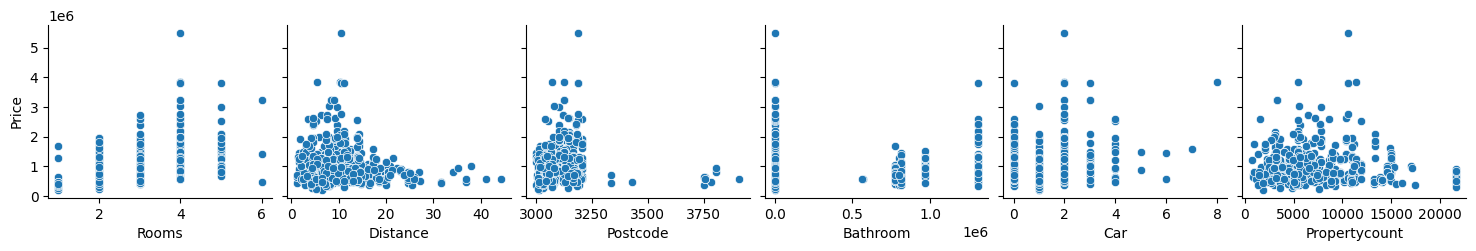

In [21]:
numeric_cols = Housing_df.select_dtypes(include=[np.number]).columns.tolist()
sns.pairplot(Housing_df, x_vars=[col for col in numeric_cols if col!='Price'], 
             y_vars='Price', kind='scatter')
plt.show()

/var/folders/82/1fv9h9_j6nzg4ys2y06tyw780000gn/T/ipykernel_86649/2279804424.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Housing_df['Price'] , fit=norm);



 mu = 1086878.06 and sigma = 645137.99



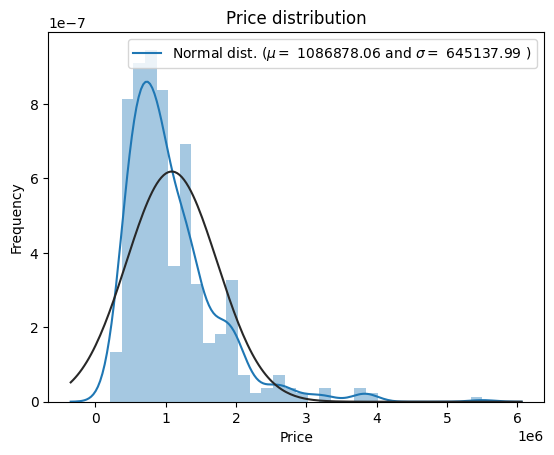

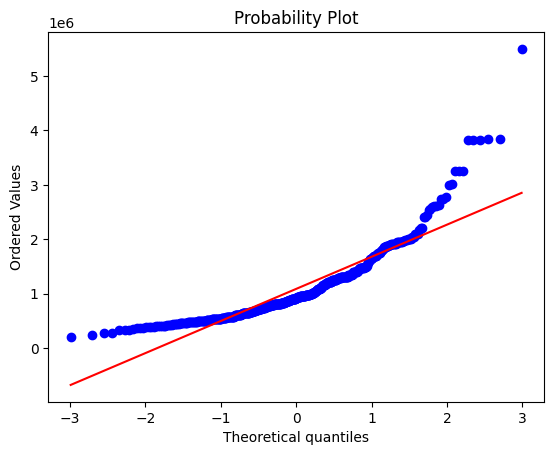

In [22]:
# I check the distribution of the dependent variable
sns.distplot(Housing_df['Price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(Housing_df['Price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(Housing_df['Price'], plot=plt)
plt.show()

### Because the response viariable is very skewed left, I take the log of it. 

/var/folders/82/1fv9h9_j6nzg4ys2y06tyw780000gn/T/ipykernel_86649/2775819861.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Housing_df['Price'] , fit=norm);



 mu = 13.76 and sigma = 0.52



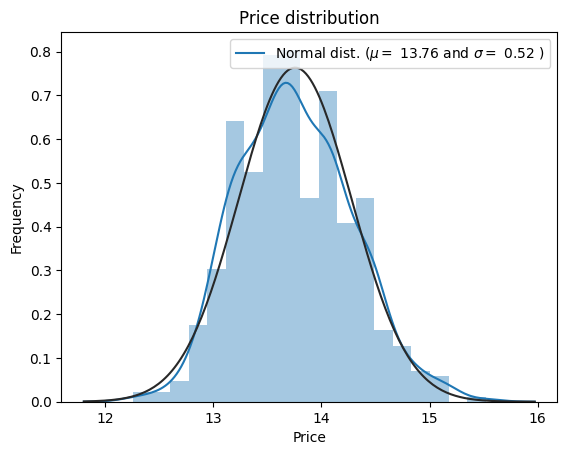

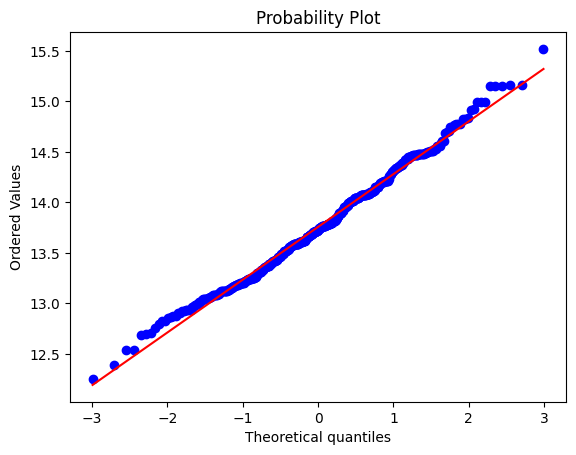

In [23]:
Housing_df["Price"] = np.log1p(Housing_df["Price"])

#Check the new distribution 
sns.distplot(Housing_df['Price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(Housing_df['Price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(Housing_df['Price'], plot=plt)
plt.show()

The distribution looks much more normal now.

### Exploring and encoding categorical variables:

In [24]:
# I check the amount of missing values in the data set once again
def display_missing_perc(Housing_df):
    """
    This is a function that evaluates the percentage of NA values per column
    """
    for col in Housing_df.columns.tolist():          
        missing_value = 100*(Housing_df[col].isnull().sum()/len(Housing_df[col]))
        missing_num = Housing_df[col].isnull().sum()
        print(f'{col} column missing values: {missing_value} ; total missing: {missing_num}') # Here, I can also see the total number of missing values.
    print('\n')
display_missing_perc(Housing_df)

Suburb column missing values: 0.0 ; total missing: 0
Rooms column missing values: 0.0 ; total missing: 0
Type column missing values: 0.0 ; total missing: 0
Price column missing values: 0.0 ; total missing: 0
Method column missing values: 0.0 ; total missing: 0
SellerG column missing values: 0.0 ; total missing: 0
Date column missing values: 0.0 ; total missing: 0
Distance column missing values: 0.0 ; total missing: 0
Postcode column missing values: 0.0 ; total missing: 0
Bathroom column missing values: 0.0 ; total missing: 0
Car column missing values: 0.0 ; total missing: 0
CouncilArea column missing values: 0.0 ; total missing: 0
Regionname column missing values: 0.0 ; total missing: 0
Propertycount column missing values: 0.0 ; total missing: 0




In [25]:
# I make sure the dates are in string format
Housing_df['Date'] = Housing_df['Date'].astype(str)

#### Encoding categorial variables

In [26]:
# Here, we are selecting which columns we cant to encode as "1, 2, 3.. etc"
from sklearn.preprocessing import LabelEncoder
cols = ['Suburb', 'Type', 'Method', 
        'SellerG', 'Date','CouncilArea', 'Regionname']
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(Housing_df[c].values)) #important: with this it will learn the number inside the column. 
    Housing_df[c] = lbl.transform(list(Housing_df[c].values))

# shape        
print('Shape all_data: {}'.format(Housing_df.shape))


Shape all_data: (499, 14)


In [27]:
print(Housing_df.head())

   Suburb  Rooms  Type      Price  Method  SellerG  Date  Distance  Postcode  \
0     164      2     2  12.989976       5       44    41       6.5      3071   
1      47      2     0  13.711262       2       61    52       7.8      3058   
2      18      3     2  13.592368       2       85    54      13.9      3165   
3     162      3     1  13.959612       2       40    48      12.4      3107   
4     149      3     2  14.304091       0       40     8       3.3      3141   

   Bathroom  Car  CouncilArea  Regionname  Propertycount  
0       1.0  1.0            6           2           8870  
1       1.0  1.0            6           2          11204  
2       2.0  2.0            8           5          10969  
3  970000.0  0.0           14           0           5420  
4       1.0  1.0           17           5          14887  


## Question 2
**Linear Regression Model Development** (15 pts): 
- Develop a Linear regression model to predict price of house in Melbourne. 
- Preprocess the data as necessary (handling missing values, encoding categorical variables, 
removing unnecessary columns etc.). 
- Explain the steps you took in preparing the data and developing the model. 
- You might need to encode the values for your prediction.

In [28]:
# this is the more "machine learning" way
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [29]:
Housing_df = Housing_df.rename(columns={'Price':'Y'})
X=Housing_df.drop('Y', axis=1)
y=Housing_df['Y']
x=sm.add_constant(X) #under this way, I need to add a constant to the X value. 
results=sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     40.23
Date:                Thu, 01 Feb 2024   Prob (F-statistic):           1.22e-68
Time:                        10:03:40   Log-Likelihood:                -201.49
No. Observations:                 499   AIC:                             431.0
Df Residuals:                     485   BIC:                             490.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             9.2979      0.537     17.309      0.000       8.242      10.353
Suburb           -0.0009      0.000     -2.867      0.004      -0.002      -0.000
Rooms             0.1865      0.022      8.325      0.000       0.142       0.230
Type             -0.2201      0.025     -8.905      0.000      -0.269      -0.172
Method            0.0064      0.008      0.767      0.443      -0.010       0.023
SellerG          -0.0002      0.001     -0.336      0.737      -0.001       0.001
Date             -0.0003      0.001     -0.418      0.676      -0.002       0.001
Distance         -0.0451      0.003    -14.238      0.000      -0.051      -0.039
Postcode          0.0015      0.000      8.363      0.000       0.001       0.002
Bathroom       2.135e-07   4.66e-08      4.577      0.000    1.22e-07    3.05e-07
Car               0.0727      0.019      3.798      0.000       0.035       0.110
CouncilArea      -0.0090      0.002     -4.802      0.000      -0.013      -0.005
Regionname        0.0018      0.008      0.223      0.824      -0.014       0.018
Propertycount -1.264e-06   4.03e-06     -0.313      0.754   -9.19e-06    6.66e-06
==============================================================================
Omnibus:                       17.727   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.652
Skew:                           0.131   Prob(JB):                     6.67e-09
Kurtosis:                       4.320   Cond. No.                     1.72e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.72e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Question 3
**Model Evaluation** (20 pts): 
- Evaluate your linear regression model using appropriate metrics. 
- Split the dataset into training and testing sets to perform this evaluation. 
- Interpret these metrics to assess the performance of your model. Is it good? Why?

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [31]:
# Splitting the dataset into training and testing sets
train, test = train_test_split(Housing_df, train_size=0.8, random_state=42)

In [32]:
# Define dependent and independent variables
X_train = train.drop('Y', axis=1)
y_train = train['Y']
X_test = test.drop('Y', axis=1)
y_test = test['Y']

#Scaling the model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and fit the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)


LinearRegression()

In [33]:
# Making predictions
preds = model.predict(X_test_scaled)

# Evaluation
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 0.13485721121820002
R-squared: 0.4068668155154296


## Question 4
**Regularization** (25 pts): 
- Is there a need for Lasso regularization? Explain. (Compare test and training results) 
- Set up a Lasso regression model with specified parameters and fit it to the training data. 
- Perform Lasso regression on both training and test data 
- Analyze and explain how the results change from previous answer

In [35]:
from sklearn.linear_model import Lasso

#initialize the Lasso model
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_scaled, y_train)

Lasso(alpha=0.01)

In [36]:
# Predict on training and testing data
train_preds_lasso = lasso.predict(X_train_scaled)
test_preds_lasso = lasso.predict(X_test_scaled)

In [37]:
# Evaluation
train_mse_lasso = mean_squared_error(y_train, train_preds_lasso)
test_mse_lasso = mean_squared_error(y_test, test_preds_lasso)
train_r2_lasso = r2_score(y_train, train_preds_lasso)
test_r2_lasso = r2_score(y_test, test_preds_lasso)

In [38]:
print(f"Training MSE with Lasso: {train_mse_lasso}")
print(f"Test MSE with Lasso: {test_mse_lasso}")
print(f"Training R-squared with Lasso: {train_r2_lasso}")
print(f"Test R-squared with Lasso: {test_r2_lasso}")

# Analyze the coefficients
print("Lasso Coefficients:", lasso.coef_)

Training MSE with Lasso: 0.1332736458147438
Test MSE with Lasso: 0.13352916032789858
Training R-squared with Lasso: 0.5300959722242715
Test R-squared with Lasso: 0.4127078902833746
Lasso Coefficients: [-0.03407329  0.18387833 -0.1828479   0.00578482  0.         -0.00319036
 -0.27863361  0.14502036  0.0663461   0.06332259 -0.06294525  0.
  0.        ]


In [39]:
# I reverse the logarithmic transformation for true values and predictions
y_train_inverse = np.expm1(y_train)
y_test_inverse = np.expm1(y_test)
train_preds_lasso_inverse = np.expm1(train_preds_lasso)
test_preds_lasso_inverse = np.expm1(test_preds_lasso)

# I evaluate my model on the original scale
train_mse_lasso_inverse = mean_squared_error(y_train_inverse, train_preds_lasso_inverse)
test_mse_lasso_inverse = mean_squared_error(y_test_inverse, test_preds_lasso_inverse)
train_r2_lasso_inverse = r2_score(y_train_inverse, train_preds_lasso_inverse)
test_r2_lasso_inverse = r2_score(y_test_inverse, test_preds_lasso_inverse)

print(f"Training MSE with Lasso (Original Scale): {train_mse_lasso_inverse}")
print(f"Test MSE with Lasso (Original Scale): {test_mse_lasso_inverse}")
print(f"Training R-squared with Lasso (Original Scale): {train_r2_lasso_inverse}")
print(f"Test R-squared with Lasso (Original Scale): {test_r2_lasso_inverse}")


Training MSE with Lasso (Original Scale): 252261300850.25052
Test MSE with Lasso (Original Scale): 213583456608.70255
Training R-squared with Lasso (Original Scale): 0.43087834664606717
Test R-squared with Lasso (Original Scale): 0.292408086107499


## Question 5
** Out-of-sample performance ** (25 pts): 
- Ignore all previously trained models. 
- Split the data into a new training and test 80-20. 
- Newly train (fit) the linear regression model on the training data. 
- Newly train (fit) the lasso regression model on the training data. 
- Estimate AIC, AICc, BIC, as well as 5-fold CV for both models using only the training data. 
- Estimate the models true OOS performance by computing their deviance on the test data. 
- Compare all (deviance) values.  Which IC is most similar to the models’ true OOS 
performance?  How does 5-fold CV compare?  Explain,

### Splitting the data

In [40]:
train, val = train_test_split(Housing_df, train_size=0.8, random_state=4761)

### Regression Model

### Training the linear regression model on the training data

In [41]:
# Define dependent and independent variables
X_train = train.drop('Y', axis=1)
y_train = train['Y']
X_test = test.drop('Y', axis=1)
y_test = test['Y']

#Scaling the model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [42]:
# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train_scaled, y_train)


LinearRegression()

### Evaluating AIC, BIC, and MSE of linear regression model and Lasso Model

In [49]:
import statsmodels.api as sm

linear_aic = results.aic
linear_bic = results.bic

print(f"Linear Regression AIC: {linear_aic}")
print(f"Linear Regression BIC: {linear_bic}")


Linear Regression AIC: 430.98970647473595
Linear Regression BIC: 489.9661918152572


In [43]:
# Making predictions
preds = model.predict(X_test_scaled)

# Evaluation
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)  # Calculate RMSE by taking the square root of MSE
r2 = r2_score(y_test, preds)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")  # Print RMSE
print(f"R-squared: {r2}")


Mean Squared Error: 0.1256739847500116
Root Mean Squared Error: 0.35450526759134565
R-squared: 0.44725676804163517


### Lasso Model


### Train the lasso regression model on the training data:

In [44]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(alphas=None, cv=5, random_state=0) # when I say 'alphas=none' I let sklearn specify the amount of alphas. 

# Fit the model
lasso_cv.fit(X_train_scaled, y_train)

# Best alpha
print(f"Best alpha: {lasso_cv.alpha_}")

Best alpha: 0.009435787354551346


#### Calculate Lasso model AIC, AICc, and BIC

In [52]:
from sklearn.linear_model import LassoLarsIC
import time

# Model based on BIC
model_bic = LassoLarsIC(criterion='bic')
t1 = time.time()
model_bic.fit(X_train_scaled, y_train)
alpha_bic_ = model_bic.alpha_

# Model based on AIC
model_aic = LassoLarsIC(criterion='aic')
t1 = time.time()
model_aic.fit(X_train_scaled, y_train)
alpha_aic_ = model_aic.alpha_

print(f"Alpha for BIC: {alpha_bic_}")
print(f"Alpha for AIC: {alpha_aic_}")


Alpha for BIC: 0.019122684859643618
Alpha for AIC: 0.004539336599760443


In [53]:
# AIC from LassoLarsIC
aic = model_aic.criterion_

# Number of parameters (non-zero coefficients in Lasso)
k = np.sum(lasso_cv.coef_ != 0)

# Sample size
n = X_train_scaled.shape[0]

# Calculate AICc
aicc = aic + (2*k*(k+1)/(n-k-1))

print(f"AIC: {aic}")
print(f"AICc: {aicc}")


AIC: [734.77895446 664.546051   586.98735337 518.44383278 464.99094998
 463.82089989 412.35466308 402.97539952 357.40463736 353.83610644
 353.5554019  347.76262386 348.77623696 350.71120573]
AICc: [735.461125   665.22822154 587.66952392 519.12600332 465.67312053
 464.50307043 413.03683362 403.65757006 358.0868079  354.51827698
 354.23757244 348.4447944  349.4584075  351.39337627]


#### Make predictions on training and testing data

In [45]:
# Predict on training and testing data
train_preds_lasso_CV = lasso_cv.predict(X_train_scaled)
test_preds_lasso_CV = lasso_cv.predict(X_test_scaled)

#### Evaluation of Prediction for Lasso

In [55]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate metrics
mse_train = mean_squared_error(y_train, train_preds_lasso_CV)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, train_preds_lasso_CV)

mse_test = mean_squared_error(y_test, test_preds_lasso_CV)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, test_preds_lasso_CV)

print(f"Training RMSE: {rmse_train}, R²: {r2_train}")
print(f"Test RMSE: {rmse_test}, R²: {r2_test}")

Training RMSE: 0.3653893184853202, R²: 0.5103541219187855
Test RMSE: 0.3557406878453646, R²: 0.44339753029037976


In [47]:
# Analyze the coefficients
print("Lasso Coefficients:", lasso.coef_)

Training MSE with Lasso: 0.13350935406316675
Test MSE with Lasso: 0.12655143698869314
Training R-squared with Lasso: 0.5103541219187855
Test R-squared with Lasso: 0.44339753029037976
Lasso Coefficients: [-0.03407329  0.18387833 -0.1828479   0.00578482  0.         -0.00319036
 -0.27863361  0.14502036  0.0663461   0.06332259 -0.06294525  0.
  0.        ]


In [48]:
# I reverse the logarithmic transformation for true values and predictions
y_train_inverse = np.expm1(y_train)
y_test_inverse = np.expm1(y_test)
train_preds_lassoCV_inverse = np.expm1(train_preds_lasso_CV)
test_preds_lassoCV_inverse = np.expm1(test_preds_lasso_CV)

# I evaluate my model on the original scale
train_mse_lassoCV_inverse = mean_squared_error(y_train_inverse, train_preds_lassoCV_inverse)
test_mse_lassoCV_inverse = mean_squared_error(y_test_inverse, test_preds_lassoCV_inverse)
train_r2_lassoCV_inverse = r2_score(y_train_inverse, train_preds_lassoCV_inverse)
test_r2_lassoCV_inverse = r2_score(y_test_inverse, test_preds_lassoCV_inverse)

print(f"Training MSE with Lasso (Original Scale): {train_mse_lassoCV_inverse}")
print(f"Test MSE with Lasso (Original Scale): {test_mse_lassoCV_inverse}")
print(f"Training R-squared with Lasso (Original Scale): {train_r2_lassoCV_inverse}")
print(f"Test R-squared with Lasso (Original Scale): {test_r2_lassoCV_inverse}")


Training MSE with Lasso (Original Scale): 247948134920.50223
Test MSE with Lasso (Original Scale): 198226094669.9415
Training R-squared with Lasso (Original Scale): 0.40731326696067904
Test R-squared with Lasso (Original Scale): 0.3432863015794787


#### Scores from 5-fold CV for both Lasso and Linear regression

In [50]:
from sklearn.model_selection import cross_val_score

# For Linear Regression
linear_cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

# For Lasso Regression
lasso_cv_scores = cross_val_score(lasso_cv, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

print(f"Linear Regression 5-fold CV: {-linear_cv_scores.mean()}")
print(f"Lasso Regression 5-fold CV: {-lasso_cv_scores.mean()}")


Linear Regression 5-fold CV: 0.14323290440439934
Lasso Regression 5-fold CV: 0.14166522323187564


In [51]:
# Calculate MSE for the predictions on test data for both models
linear_test_mse = mean_squared_error(y_test, preds)  # preds from Linear Regression
lasso_test_mse = mean_squared_error(y_test, test_preds_lasso)  # test_preds_lasso from Lasso

print(f"Linear Regression Test MSE: {linear_test_mse}")
print(f"Lasso Regression Test MSE: {lasso_test_mse}")


Linear Regression Test MSE: 0.1256739847500116
Lasso Regression Test MSE: 0.13352916032789858


#### Comparing OOS based on Deviance

In [58]:
# Define the deviance function
def deviance(y, pred, family="gaussian"):
    if family == "gaussian":
        return np.sum((y - pred) ** 2)
    elif family == "binomial":
        y = np.array(y)
        pred = np.array(pred)
        return -2 * np.sum(y * np.log(pred) + (1 - y) * np.log(1 - pred))

In [59]:
# Predictions for the Linear Regression model
linear_preds = model.predict(X_test_scaled)  # model is the Linear Regression model

# Predictions for the Lasso model
lasso_preds = lasso_cv.predict(X_test_scaled)  # lasso_cv is the Lasso model

# Calculate deviance for the Linear Regression model
linear_deviance = deviance(y_test, linear_preds, family="gaussian")

# Calculate deviance for the Lasso model
lasso_deviance = deviance(y_test, lasso_preds, family="gaussian")

print(f"Deviance for Linear Model: {linear_deviance}")
print(f"Deviance for Lasso Model: {lasso_deviance}")


Deviance for Linear Model: 12.567398475001161
Deviance for Lasso Model: 12.655143698869315


#### Model comparison

For the Linear Regression Model, I have:

    AIC: 430.98970647473595
    BIC: 489.9661918152572
    Test MSE: 0.1256739847500116
    Test Deviance: 12.567398475001161

For the Lasso Model, I have:

    Best alpha: 0.009435787354551346
    Test MSE: 0.13352916032789858
    Test Deviance: 12.655143698869315

The Linear Regression model has lower AIC and BIC, suggesting it might be more efficient in terms of the trade-off between goodness of fit and complexity.
The OOS performance (Test MSE and Deviance) is quite similar between the two models, with Linear Regression having a slightly better (lower) Test MSE and Deviance. This suggests that despite the regularization in Lasso, the Linear Regression model is performing comparably or slightly better in this specific case.

Both models perform similarly in CV, with the Lasso model having a slightly lower average MSE in CV compared to the Linear model.  The 5-fold CV results support the conclusion that both of my models are competitive, with Lasso showing a tiny advantage in CV but slightly higher Test MSE. 

The deviance values are very close for both models, this indicates similar performance in terms of fit to the data. 
